In [5]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from sktime.datasets import load_UCR_UEA_dataset

import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

import torch
from torch import nn, optim
from torch.utils.data import DataLoader

from deeptime.data import BaseDataset
from deeptime.models.representation import ResNetAutoEncoder

In [6]:
DATASETS = [
    'Yoga',
    # 'WormsTwoClass',
    # 'Wine',
    # 'Wafer',
    # 'TwoLeadECG',
    # 'Strawberry',
    # 'SemgHandGenderCh2', 
    # 'BeetleFly',
    # 'BirdChicken',
    # 'Computers',
    # 'DistalPhalanxOutlineCorrect',
    # 'Earthquakes',
    # 'ECG200',
    # 'ECGFiveDays',
    # 'FordA',
    # 'FordB',
    # 'HandOutlines',
    # 'ItalyPowerDemand', 
    # 'MiddlePhalanxOutlineCorrect',
    # 'Chinatown',
    # 'FreezerRegularTrain',
    # 'FreezerSmallTrain',
    # 'GunPointAgeSpan',
    # 'GunPointMaleVersusFemale',
    # 'GunPointOldVersusYoung',
    # 'PowerCons',
    # 'Coffee',
    # 'Ham',
    # 'Herring',
    # 'Lightning2',
    # 'MoteStrain',
    # 'PhalangesOutlinesCorrect',
    # 'ProximalPhalanxOutlineCorrect',
    # 'ShapeletSim',
    # 'SonyAIBORobotSurface1',
    # 'SonyAIBORobotSurface2',
    # 'ToeSegmentation1',
    # 'ToeSegmentation2',
    # 'HouseTwenty'
]

In [7]:
class LitProgressBar(pl.callbacks.TQDMProgressBar):

    def init_validation_tqdm(self):
        bar = tqdm(
            disable=True,
        )
        return bar

In [ ]:
for dataset in DATASETS:
    print(f'\tDownloading the {dataset} dataset...')
    x_train, y_train = load_UCR_UEA_dataset(name=dataset, split='train')
    # Since the features from the sktime are instatiated as objects we have to manually convert them
    y_train = np.array(y_train, dtype=np.int32)

    sequence_length = x_train.values[0][0].shape[0]

    x_test, y_test = load_UCR_UEA_dataset(name=dataset, split='test')
    y_test = np.array(y_test, dtype='int32') # Fixing the labels type
    print(f'\t\tDownload completed!')

    print('\tTransforming data to the correct format...')
    x_train_transformed = []
    for val in x_train.values:
        x_train_transformed.append(val[0].tolist())
    x_train = np.array(x_train_transformed)

    x_test_transformed = []
    for val in x_test.values:
        x_test_transformed.append(val[0].tolist())
    x_test = np.array(x_test_transformed)
    
    x_train = np.expand_dims(x_train_transformed, axis=1)
    x_test = np.expand_dims(x_test_transformed, axis=1)
    print('\t\tTransform completed!')
    
    unique_labels = np.unique(y_train)
    for label in unique_labels:
        print(f'\t\t\t Learning the label {label}...')
        print()
        
        x_train_ = x_train[y_train == label]
        y_train_ = y_train[y_train == label]

        occ_labels = [1 if x == label else -1 for x in y_test]

        train_dataset = BaseDataset(x=x_train, y=y_train)
        train_loader = DataLoader(train_dataset, batch_size=32)
        
        test_dataset = BaseDataset(x=x_test, y=y_test)
        test_loader = DataLoader(test_dataset, batch_size=32)
        
        model = ResNetAutoEncoder(
            in_channels=1,
            in_features=sequence_length,
            mid_channels=64,
            latent_dim=32,
            learning_rate=5e-4
        )
        
        trainer = pl.Trainer(
            max_epochs=300,
            accelerator='gpu',
            devices=-1,
            callbacks=[
                EarlyStopping(monitor='val_loss', mode='min', patience=50, min_delta=0.001)
            ]
        )
        
        trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=test_loader)
        torch.save(
            model.state_dict(),
            f'../../../pretrain/representation/{dataset}/resnet_ae-l{label}-dim{32}.pth'
        )

    print('-' * 100)

		Download completed!
	Transforming data to the correct format...
		Transform completed!
			 Learning the label 1...



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | e    | Sequential | 14.5 M
1 | d    | Sequential | 14.4 M
------------------------------------
28.9 M    Trainable params
0         Non-trainable params
28.9 M    Total params
115.463   Total estimated model params size (MB)


Epoch 0:  10%|████▉                                              | 10/104 [00:00<00:05, 16.33it/s, loss=0.676, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 1:  10%|███▎                               | 10/104 [00:00<00:04, 19.65it/s, loss=0.466, v_num=4, val_loss=0.659]
Validation: 0it [00:00, ?it/s]
Epoch 2:  10%|███▎                               | 10/104 [00:00<00:04, 21.07it/s, loss=0.218, v_num=4, val_loss=0.317]
Validation: 0it [00:00, ?it/s]
Epoch 3:  10%|███▎                               | 10/104 [00:00<00:04, 21.61it/s, loss=0.155, v_num=4, val_loss=0.210]
Validation: 0it [00:00, ?it/s]
Epoch 4:  10%|███▎                               | 10/104 [00:00<00:04, 21.23it/s, loss=0.118, v_num=4, val_loss=0.153]
Validation: 0it [00:00, ?it/s]
Epoch 5:  10%|███▎                              | 10/104 [00:00<00:05, 17.42it/s, loss=0.0937, v_num=4, val_loss=0.116]
Validation: 0it [00:00, ?it/s]
Epoch 6:  10%|███▎                              | 10/104 [00:00<00:06, 15.29it/s, loss=0.0762,

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 25:  10%|███                             | 10/104 [00:00<00:05, 16.10it/s, loss=0.0189, v_num=5, val_loss=0.0417]
Validation: 0it [00:00, ?it/s]
Epoch 26:  10%|███                             | 10/104 [00:00<00:05, 16.95it/s, loss=0.0183, v_num=5, val_loss=0.0385]
Validation: 0it [00:00, ?it/s]
Epoch 27:  10%|███                             | 10/104 [00:00<00:05, 17.51it/s, loss=0.0171, v_num=5, val_loss=0.0384]
Validation: 0it [00:00, ?it/s]
Epoch 28:  10%|███                             | 10/104 [00:00<00:05, 16.42it/s, loss=0.0162, v_num=5, val_loss=0.0409]
Validation: 0it [00:00, ?it/s]
Epoch 29:  10%|███                             | 10/104 [00:00<00:05, 16.78it/s, loss=0.0151, v_num=5, val_loss=0.0354]
Validation: 0it [00:00, ?it/s]
Epoch 30:  10%|███▏                             | 10/104 [00:00<00:05, 17.24it/s, loss=0.014, v_num=5, val_loss=0.0379]
Validation: 0it [00:00, ?it/s]
Epoch 31:  10%|███                             | 10/104 [00:00<00:05, 17.48it/s, loss=0.0134, 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 79:  10%|██▉                            | 10/104 [00:00<00:05, 17.53it/s, loss=0.00984, v_num=5, val_loss=0.0369]
Validation: 0it [00:00, ?it/s]
Epoch 80:  10%|███                             | 10/104 [00:00<00:05, 17.92it/s, loss=0.0102, v_num=5, val_loss=0.0379]
Validation: 0it [00:00, ?it/s]
Epoch 81:  10%|███                             | 10/104 [00:00<00:05, 17.86it/s, loss=0.0105, v_num=5, val_loss=0.0443]
Validation: 0it [00:00, ?it/s]
Epoch 82:  10%|███                             | 10/104 [00:00<00:05, 18.08it/s, loss=0.0102, v_num=5, val_loss=0.0366]
Validation: 0it [00:00, ?it/s]
Epoch 83:  10%|██▉                            | 10/104 [00:00<00:05, 18.62it/s, loss=0.00988, v_num=5, val_loss=0.0598]
Validation: 0it [00:00, ?it/s]
Epoch 84:  10%|███                             | 10/104 [00:00<00:05, 17.70it/s, loss=0.0101, v_num=5, val_loss=0.0407]
Validation: 0it [00:00, ?it/s]
Epoch 85:  10%|███                             | 10/104 [00:00<00:05, 17.61it/s, loss=0.00971,

In [2]:
train_dataset = UCRDataset(name='FordA', split='train')
len(train_dataset)

3601

In [3]:
test_dataset = UCRDataset(name='FordA', split='test')
len(test_dataset)

1320

In [4]:
unique_labels = torch.unique(train_dataset[:][1])
unique_labels

tensor([-1.,  1.])

In [6]:
for label in unique_labels:
    x_train, y_train = train_dataset[label == train_dataset[:][1]]

    filtered_dataset = BaseDataset(
        x=np.array(x_train.tolist()),
        y=np.array(y_train.tolist())
    )

    train_loader = DataLoader(filtered_dataset, batch_size=16)

    autoencoder = ResNetAutoEncoder(in_channels=1, in_features=500, latent_dim=32)
    trainer = pl.Trainer(
        max_epochs=500,
        accelerator='gpu',
        devices=-1,
        callbacks=[EarlyStopping(monitor='train_loss', mode='min', patience=10, min_delta=0.01)]
    )

    trainer.fit(model=autoencoder, train_dataloaders=train_loader)
    break

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\medei\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | e    | Sequential | 16.9 M
1 | d    | Sequential | 16.8 M
------------------------------------
33.7 M    Trainable params
0         Non-trainable params
33.7 M    Total params
134.862   Total estimated model params size (MB)
C:\Users\medei\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasi

Epoch 40: 100%|████████████████████████████████████████████████| 116/116 [00:15<00:00,  7.61it/s, loss=0.0714, v_num=9]


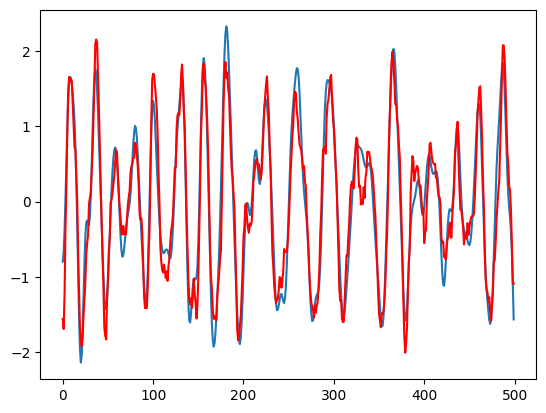

In [7]:
import matplotlib.pyplot as plt

x_hat, z = autoencoder(train_dataset[:1][0])

plt.plot(list(range(500)), train_dataset[0][0].view(-1).tolist())
plt.plot(list(range(500)), x_hat.view(-1).tolist(), color='red')